<a href="https://colab.research.google.com/github/ahmadkhan242/PlayingWithMNIST/blob/main/task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3

Downloading the given dataset.

In [ ]:
!wget https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip

In [ ]:
!unzip mnistTask3.zip

## For this task I had used Pytorch library to implement CNN.

In [10]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

import torch.nn as nn
import os,shutil,json
import argparse
import glob
import torch.utils.data
import math
from skimage import io, transform
from PIL import Image
import torchvision as vision
from torchvision import transforms, datasets
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

torch.cuda.empty_cache()

In [11]:
# Defining dataset directory 
root_dir = "/content/mnistTask/"

### The funtion below is used to create train and validation loader.

In [14]:

def prepare_dataset(dataset_path):
  """ Function to create train and validation loader.
    Params:
        dataset_path: path where all images are.
    
    returns: 
        train_loader: train loader with batch size of 64
        validation_loader: validation loader with batch size of 64
        
    Note: Split ratio and batch sizes are pre-defined you can change it in this function.
    """

  labels = os.listdir(dataset_path)

  # Here images are resized and converted to grayscale so that we have data consistency for other tasks
  dataset = ImageFolder(
      dataset_path,
      transforms.Compose([transforms.Resize((32,32)),
                         transforms.ToTensor(),transforms.Grayscale(num_output_channels=1)])
  )
  # Validation split 15%
  val_split = int(len(dataset)*0.15)
  train_split = len(dataset) - val_split

  train_dataset, val_dataset = random_split(dataset, [train_split, val_split])

  # to make sure the split is right.
  assert (len(train_dataset)+len(val_dataset)) == len(dataset)

  train_loader = torch.utils.data.DataLoader(train_dataset, 64, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(val_dataset, 64) 

  return (train_loader, validation_loader)


In [15]:
# executing prepare_dataset function
train_loader, validation_loader = prepare_dataset(root_dir)

### Data visualisation 

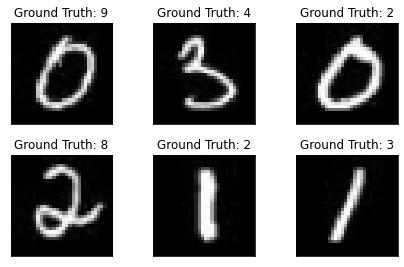

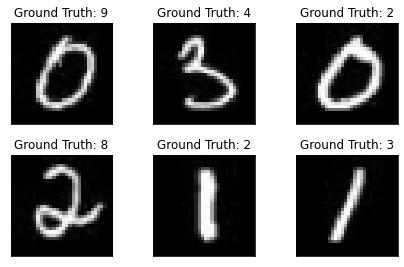

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Here the CNN architecture  is defined, the architecture is of ResNet with four layers and one resedual block in each layer( See conclusion for detail).

In [2]:

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=(3,3), bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=(4,4), stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear1 = nn.Linear(512, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.4)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 5)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 5)
        out = torch.flatten(out, 1)
        out = self.linear1(out)
        out = self.dropout1(out)
        out = self.linear2(out)
        out = self.dropout2(out)
        out = self.linear3(out)
        return out


### In the cell below, defined the Model, the loss function, and the Optimizer I have used for this task. 

In [ ]:
model = ResNet(BasicBlock, [1, 1, 1, 1])

criterion = nn.CrossEntropyLoss()
torch.cuda.empty_cache()

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	model = model.cuda()
	optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
	criterion = criterion.cuda()

Tesla P100-PCIE-16GB


### Here the train function is defined for training the model defined above.
### Please follow the comment to guide your self in the train function.

In [ ]:
# Loss and accuracy list are defined, these lists are used for graph.
%%time
train_loss_list = []
val_loss_list = []
epc_list = []
train_acc_list = []
val_acc_list = []
incorrect_examples=[]

def train():
  best_valid_loss = float('Inf')
  print("Training Started !!!")
  for i in range(50):
    training_loss = 0
    tcorrect = 0
    ttotal = 0
    model.train()
    for features, labels in train_loader:
      # Label and features assigning
      features, labels = Variable(features.cuda()), Variable(labels.cuda())
      optimizer.zero_grad()

      # Output collection from model
      outputs = model(features.float())

      # Loss calculation and updation
      losss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())
      losss.backward()
      optimizer.step()
      training_loss += losss.item()

      # Prediction
      _, pred = torch.max(outputs, 1)
      ttotal+= labels.reshape(-1).size(0)
      tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
  
    validation_loss = 0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
      for features, labels in validation_loader:

        # Label and features assigning
        features, labels = Variable(features.cuda()), Variable(labels.cuda())

        # Output collection from model
        outputs = model(features.float())
        
        # Loss calculation
        loss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())

        # Prediction
        _, pred = torch.max(outputs, 1)
        total+= labels.reshape(-1).size(0)
        correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
        validation_loss += loss.item()


    train_loss_list.append(training_loss/len(train_loader))
    val_loss_list.append(validation_loss/len(validation_loader))
    epc_list.append(i)
    train_acc_list.append(100*(tcorrect/ttotal))
    val_acc_list.append(100*(correct/total))
    if best_valid_loss > validation_loss:
        best_valid_loss = validation_loss 
        # Saving Best Pre-Trained Model as .pth file
        torch.save(model, "task3.pth")
    print("Epoch {} - \nTraning loss: {}".format(i+1, training_loss/len(train_loader)))
    print("Validation loss: {}".format( validation_loss/len(validation_loader)))
    print("Trainig Accuracy: {}".format( 100*(tcorrect/ttotal)))
    print("Validation Accuracy: {}".format(100*(correct/total)))

train()
print("Training Complete")

Training Started !!!
Epoch 1 - 
Traning loss: 2.3076755653510577
Validation loss: 2.2951010896804487
Trainig Accuracy: 10.323529411764707
Validation Accuracy: 10.044444444444444
Epoch 2 - 
Traning loss: 2.297308984185701
Validation loss: 2.2933622167465533
Trainig Accuracy: 10.776470588235295
Validation Accuracy: 10.311111111111112
Epoch 3 - 
Traning loss: 2.2959666527349647
Validation loss: 2.2915432791337897
Trainig Accuracy: 10.907843137254902
Validation Accuracy: 10.411111111111111
Epoch 4 - 
Traning loss: 2.2957662978166318
Validation loss: 2.291815794951527
Trainig Accuracy: 10.882352941176471
Validation Accuracy: 11.122222222222222
Epoch 5 - 
Traning loss: 2.2934215148090566
Validation loss: 2.285887380018302
Trainig Accuracy: 10.75294117647059
Validation Accuracy: 10.755555555555556
Epoch 6 - 
Traning loss: 2.2895178012596618
Validation loss: 2.2888379959349936
Trainig Accuracy: 11.180392156862744
Validation Accuracy: 10.777777777777779
Epoch 7 - 
Traning loss: 2.28460846342137

### Graph plot of training accuracy and validation accuracy with no of epochs.


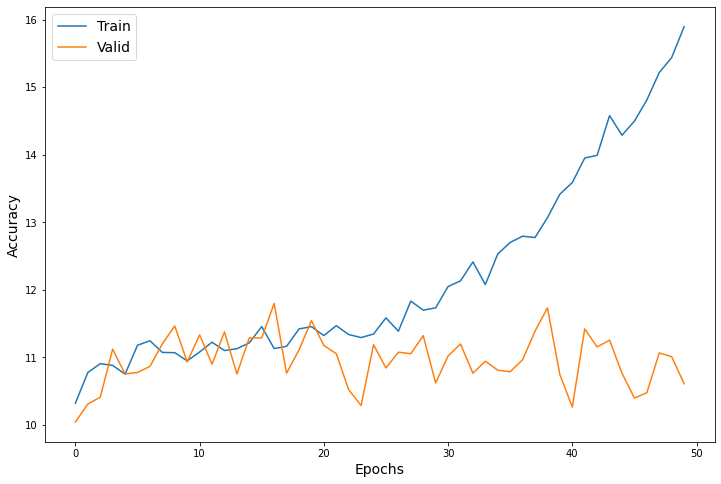

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(epc_list, train_acc_list, label='Train')
plt.plot(epc_list, val_acc_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Graph plot of training loss and validation loss with no of epochs.


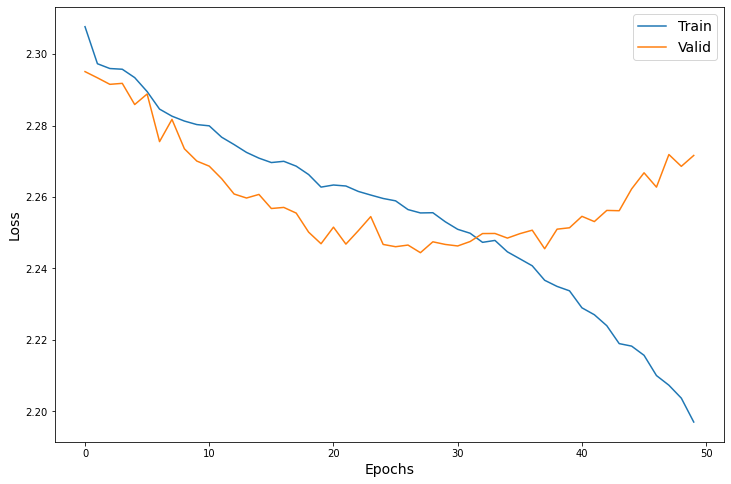

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(epc_list, train_loss_list, label='Train')
plt.plot(epc_list, val_loss_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Downloading MNIST dataset from pytorch datasets API.

In [6]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((32, 32))
        ])

# Load and transform data
trainset = datasets.MNIST('/mnist', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

testset = datasets.MNIST('/mnist', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)


Extracting /mnist/MNIST/raw/train-images-idx3-ubyte.gz to /mnist/MNIST/raw




Extracting /mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /mnist/MNIST/raw




Extracting /mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /mnist/MNIST/raw




Extracting /mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Validating above model on MNIST testset.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.float().cuda())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy of the network on the MNIST test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the MNIST test images: 4 %


# Now training above dataset using pre-trained weights of model we trained in the first task.

In [3]:
pre_trained = torch.load("final_task.pth")

# Since, In first task we trained model for 62 class, we have to change the final 
# layer to train it for 10 classes
num_ftrs = pre_trained.linear2.out_features
pre_trained.linear3 = nn.Linear(num_ftrs, 10)
print(pre_trained)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128,

### In the cell below, defined the Model, the loss function, and the Optimizer I have used for this task. 

In [17]:
mnist_model = pre_trained
criterion = nn.CrossEntropyLoss()
torch.cuda.empty_cache()

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	model1 = mnist_model.cuda()
	optimizer = optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-5)
	criterion = criterion.cuda()

Tesla P100-PCIE-16GB


In [18]:
%%time
train_loss_list = []
val_loss_list = []
epc_list = []
train_acc_list = []
val_acc_list = []
incorrect_examples=[]

def train():
  best_valid_loss = float('Inf')
  print("Training Started !!!")
  for i in range(50):
    training_loss = 0
    tcorrect = 0
    ttotal = 0
    model1.train()
    for features, labels in train_loader:
      # Label and features assigning
      features, labels = Variable(features.cuda()), Variable(labels.cuda())
      optimizer.zero_grad()

      # Output collection from model1
      outputs = model1(features.float())

      # Loss calculation and updation
      losss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())
      losss.backward()
      optimizer.step()
      training_loss += losss.item()

      # Prediction
      _, pred = torch.max(outputs, 1)
      ttotal+= labels.reshape(-1).size(0)
      tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
  
    validation_loss = 0
    correct = 0
    total = 0
    model1.eval()
    with torch.no_grad():
      for features, labels in validation_loader:

        # Label and features assigning
        features, labels = Variable(features.cuda()), Variable(labels.cuda())

        # Output collection from model1
        outputs = model1(features.float())
        
        # Loss calculation
        loss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())

        # Prediction
        _, pred = torch.max(outputs, 1)
        total+= labels.reshape(-1).size(0)
        correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
        validation_loss += loss.item()


    train_loss_list.append(training_loss/len(train_loader))
    val_loss_list.append(validation_loss/len(validation_loader))
    epc_list.append(i)
    train_acc_list.append(100*(tcorrect/ttotal))
    val_acc_list.append(100*(correct/total))
    if best_valid_loss > validation_loss:
        best_valid_loss = validation_loss 
        # Saving Best Pre-Trained Model1 as .pth file
        torch.save(model1, "pre1_task3.pth")
    print("Epoch {} - \nTraning loss: {}".format(i+1, training_loss/len(train_loader)))
    print("Validation loss: {}".format( validation_loss/len(validation_loader)))
    print("Trainig Accuracy: {}".format( 100*(tcorrect/ttotal)))
    print("Validation Accuracy: {}".format(100*(correct/total)))

train()
print("Training Complete")

Training Started !!!
Epoch 1 - 
Traning loss: 2.3930121425403703
Validation loss: 2.28058156392253
Trainig Accuracy: 10.984313725490196
Validation Accuracy: 11.555555555555555
Epoch 2 - 
Traning loss: 2.2913611365980007
Validation loss: 2.2717464190002876
Trainig Accuracy: 11.24705882352941
Validation Accuracy: 11.833333333333334
Epoch 3 - 
Traning loss: 2.279292748294481
Validation loss: 2.2575644161684294
Trainig Accuracy: 10.886274509803922
Validation Accuracy: 11.38888888888889
Epoch 4 - 
Traning loss: 2.2672780592139423
Validation loss: 2.2554893984016795
Trainig Accuracy: 11.415686274509804
Validation Accuracy: 10.644444444444444
Epoch 5 - 
Traning loss: 2.2623046258162973
Validation loss: 2.2473771825749824
Trainig Accuracy: 11.307843137254903
Validation Accuracy: 11.188888888888888
Epoch 6 - 
Traning loss: 2.2590461468307708
Validation loss: 2.2438066107161503
Trainig Accuracy: 10.96078431372549
Validation Accuracy: 10.4
Epoch 7 - 
Traning loss: 2.2559255270317777
Validation lo

### Graph plot of training loss and validation loss with no of epochs.


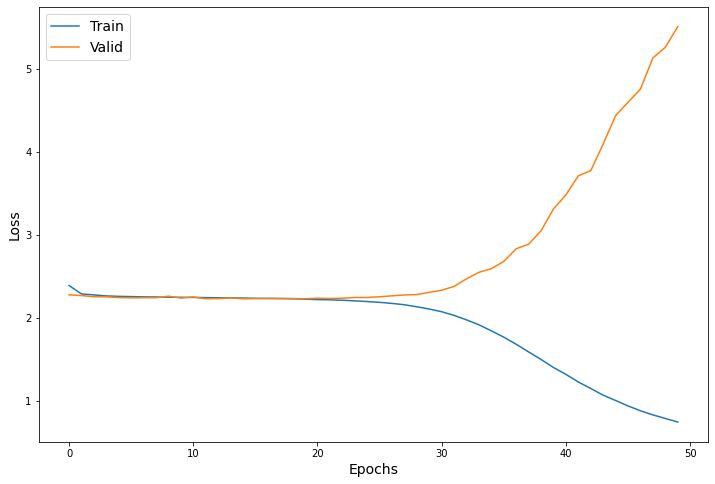

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(range(0, 50), train_loss_list, label='Train')
plt.plot(range(0, 50), val_loss_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Graph plot of training accuracy and validation accuracy with no of epochs.

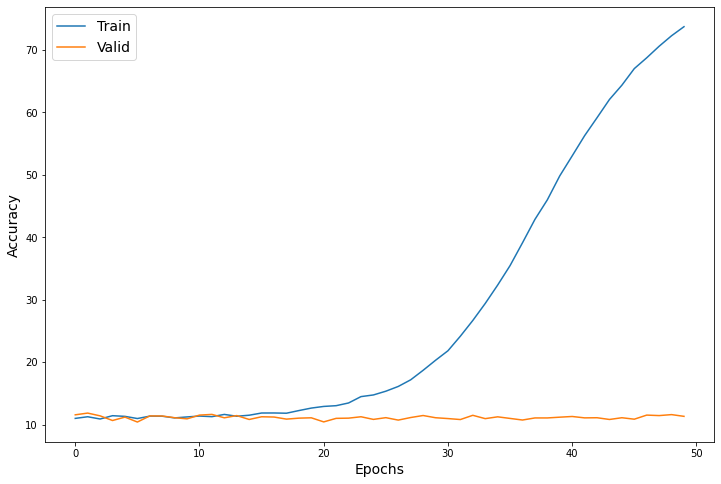

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(range(0, 50), train_acc_list, label='Train')
plt.plot(range(0, 50), val_acc_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Validating above model of MNIST test dataset

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model1(images.float().cuda())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy of the network on the MNIST test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the MNIST test images: 0 %


### Conclusion  - 
* `Dataset` -   
### Dataset information  -  
  * No of classes - 10 
  * Total samples - 60,000

  ### Validation split of 15% was used.
  ### Pre-Processing  
  * Images were resized to 32x32 to reduce computational power.
  * Images were converted to grayscale(single channel) so that we have data consistency for other tasks.
* `Model` - For this task Resnet architecture  was used with 4 layers and 1 resudual block in each layer, and finally three linear layers where used with dropout in first linear layer and second linear layer.

  <details> 
    <summary>Complete Architecture summary</summary>
    
  ```bash
        ----------------------------------------------------------------
                Layer (type)               Output Shape         Param #
        ================================================================
                    Conv2d-1           [-1, 64, 32, 32]             576
               BatchNorm2d-2           [-1, 64, 32, 32]             128
                    Conv2d-3           [-1, 64, 32, 32]          36,864
               BatchNorm2d-4           [-1, 64, 32, 32]             128
                    Conv2d-5           [-1, 64, 32, 32]          36,864
               BatchNorm2d-6           [-1, 64, 32, 32]             128
                BasicBlock-7           [-1, 64, 32, 32]               0
                    Conv2d-8          [-1, 128, 32, 32]          73,728
               BatchNorm2d-9          [-1, 128, 32, 32]             256
                   Conv2d-10          [-1, 128, 32, 32]         147,456
              BatchNorm2d-11          [-1, 128, 32, 32]             256
                   Conv2d-12          [-1, 128, 32, 32]           8,192
              BatchNorm2d-13          [-1, 128, 32, 32]             256
               BasicBlock-14          [-1, 128, 32, 32]               0
                   Conv2d-15          [-1, 256, 32, 32]         294,912
              BatchNorm2d-16          [-1, 256, 32, 32]             512
                   Conv2d-17          [-1, 256, 32, 32]         589,824
              BatchNorm2d-18          [-1, 256, 32, 32]             512
                   Conv2d-19          [-1, 256, 32, 32]          32,768
              BatchNorm2d-20          [-1, 256, 32, 32]             512
               BasicBlock-21          [-1, 256, 32, 32]               0
                   Conv2d-22            [-1, 512, 6, 6]       1,179,648
              BatchNorm2d-23            [-1, 512, 6, 6]           1,024
                   Conv2d-24            [-1, 512, 6, 6]       2,359,296
              BatchNorm2d-25            [-1, 512, 6, 6]           1,024
                   Conv2d-26            [-1, 512, 6, 6]         131,072
              BatchNorm2d-27            [-1, 512, 6, 6]           1,024
               BasicBlock-28            [-1, 512, 6, 6]               0
                   Linear-29                  [-1, 256]         131,328
                  Dropout-30                  [-1, 256]               0
                   Linear-31                  [-1, 128]          32,896
                  Dropout-32                  [-1, 128]               0
                   Linear-33                   [-1, 64]           8,256
        ================================================================
        Total params: 5,069,440
        Trainable params: 5,069,440
        Non-trainable params: 0
        ----------------------------------------------------------------
        Input size (MB): 0.00
        Forward/backward pass size (MB): 25.49
        Params size (MB): 19.34
        Estimated Total Size (MB): 44.83
        ----------------------------------------------------------------

  ```
</details> 

* `Training Methodology` -
  * Epoch = 50     
  * Learning rate - 0.001.
  * weight decay - 0.0001.
  * Training batch size = 64
  * Validation batch size = 64
  * Batch Normalisation and Dropout of 0.3 and 0.4 where used.  

* `Results` -  
  * `Using pre-trained weights`
      * Max Training accuracy - 73
      * Max Validation accuracy - 11.5
  * `Using random weights`
      * Max Training accuracy - 15.3
      * Max Validation accuracy - 11.7

### `Report` -
  * The Dataset given for this task was randomize, Ideally the folder 0 should have all images of 0 digit but instead randome digit were given, this was the case for all classes.
  * From the above results, it is clear that the model did not learn to classify 0-9 digits, when tested on MNIST test dataset the prediction was 4%, which was surprising.
  * But when we trained the model initialised with the pre-trained weights of the model trained in frist task, no improvement was seen instead it started underfitting, when tested on MNIST test set it performed worst and the accuracy was 0%.
  * The model initialized with pre-trained weights
    * Loss in first epoch - `2.390` (training), `2.280` (validation)
    * Loss in last epoch - `0.747` (training), `5.511` (validation)
  * The model initialized with random weights(inbuit in pytorch)
    * Loss in first epoch - `2.307` (training), `2.295` (validation)
    * Loss in last epoch - `2.197` (training), `0.0229` (validation)
  * Both model took nearly equal time to converge

* `Refrence`
  * https://github.com/pytorch/vision
  * https://pytorch.org/tutorials/beginner/saving_loading_models.html
  * https://github.com/ahmadkhan242/Transfer-Learning-Model-hosted-on-Heroku-using-React-Flask